In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.5)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [8]:
n_classes = len(np.unique(train_val_labels))
clf = models.resnet18(pretrained=True)

for param in clf.parameters():
    param.requires_grad = False
    
clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
clf = clf.to('cuda')
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.4294599394121565


epoch:   3%|██▌                                                                        | 1/30 [01:52<54:31, 112.80s/it]


Epoch 001 train_loss: 2.4295     val_loss 1.3821 train_acc 0.4343 val_acc 0.7064
loss 0.8392718569442383


epoch:   7%|█████                                                                      | 2/30 [03:36<51:18, 109.94s/it]


Epoch 002 train_loss: 0.8393     val_loss 0.5856 train_acc 0.7930 val_acc 0.8477
loss 0.4372842376621922


epoch:  10%|███████▌                                                                   | 3/30 [05:15<48:05, 106.87s/it]


Epoch 003 train_loss: 0.4373     val_loss 0.4551 train_acc 0.8850 val_acc 0.8758
loss 0.26536636892918924


epoch:  13%|██████████                                                                 | 4/30 [06:59<45:51, 105.81s/it]


Epoch 004 train_loss: 0.2654     val_loss 0.3220 train_acc 0.9295 val_acc 0.9189
loss 0.20670560627895224


epoch:  17%|████████████▌                                                              | 5/30 [08:41<43:42, 104.88s/it]


Epoch 005 train_loss: 0.2067     val_loss 0.2597 train_acc 0.9473 val_acc 0.9359
loss 0.162403895192779


epoch:  20%|███████████████                                                            | 6/30 [10:23<41:31, 103.83s/it]


Epoch 006 train_loss: 0.1624     val_loss 0.2603 train_acc 0.9560 val_acc 0.9362
loss 0.11994772404432297


epoch:  23%|█████████████████▌                                                         | 7/30 [12:07<39:52, 104.01s/it]


Epoch 007 train_loss: 0.1199     val_loss 0.2406 train_acc 0.9719 val_acc 0.9421
loss 0.07135924092324333


epoch:  27%|████████████████████                                                       | 8/30 [13:52<38:16, 104.37s/it]


Epoch 008 train_loss: 0.0714     val_loss 0.2318 train_acc 0.9834 val_acc 0.9481
loss 0.055183557936307075


epoch:  30%|██████████████████████▌                                                    | 9/30 [15:35<36:23, 103.96s/it]


Epoch 009 train_loss: 0.0552     val_loss 0.2258 train_acc 0.9857 val_acc 0.9484
loss 0.05020298742055403


epoch:  33%|████████████████████████▋                                                 | 10/30 [17:18<34:29, 103.49s/it]


Epoch 010 train_loss: 0.0502     val_loss 0.2194 train_acc 0.9876 val_acc 0.9510
loss 0.04104259385749729


epoch:  37%|███████████████████████████▏                                              | 11/30 [19:01<32:43, 103.33s/it]


Epoch 011 train_loss: 0.0410     val_loss 0.2368 train_acc 0.9899 val_acc 0.9475
loss 0.03252339136433481


epoch:  40%|█████████████████████████████▌                                            | 12/30 [20:43<30:52, 102.91s/it]


Epoch 012 train_loss: 0.0325     val_loss 0.2412 train_acc 0.9910 val_acc 0.9510
loss 0.027883916849190973


epoch:  43%|████████████████████████████████                                          | 13/30 [22:26<29:10, 102.96s/it]


Epoch 013 train_loss: 0.0279     val_loss 0.2382 train_acc 0.9928 val_acc 0.9529
loss 0.028967235492339663


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [24:06<27:16, 102.29s/it]


Epoch 014 train_loss: 0.0290     val_loss 0.2501 train_acc 0.9920 val_acc 0.9467
loss 0.015526947281737417


epoch:  50%|█████████████████████████████████████                                     | 15/30 [25:47<25:26, 101.77s/it]


Epoch 015 train_loss: 0.0155     val_loss 0.2319 train_acc 0.9963 val_acc 0.9551
loss 0.011724016909586014


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [27:28<23:41, 101.56s/it]


Epoch 016 train_loss: 0.0117     val_loss 0.2379 train_acc 0.9968 val_acc 0.9555
loss 0.01269122676837573


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [29:08<21:55, 101.22s/it]


Epoch 017 train_loss: 0.0127     val_loss 0.2419 train_acc 0.9976 val_acc 0.9544
loss 0.012382057636437006


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [30:47<20:05, 100.44s/it]


Epoch 018 train_loss: 0.0124     val_loss 0.2508 train_acc 0.9972 val_acc 0.9530
loss 0.010680410005998186


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [32:29<18:30, 100.96s/it]


Epoch 019 train_loss: 0.0107     val_loss 0.2386 train_acc 0.9976 val_acc 0.9560
loss 0.011127078750424471


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [34:12<16:55, 101.58s/it]


Epoch 020 train_loss: 0.0111     val_loss 0.2608 train_acc 0.9973 val_acc 0.9505
loss 0.011162271138468205


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [35:54<15:15, 101.74s/it]


Epoch 021 train_loss: 0.0112     val_loss 0.2736 train_acc 0.9976 val_acc 0.9518
loss 0.006571101758568743


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [37:35<13:31, 101.40s/it]


Epoch 022 train_loss: 0.0066     val_loss 0.2521 train_acc 0.9990 val_acc 0.9557
loss 0.00566697567317083


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [39:18<11:52, 101.80s/it]


Epoch 023 train_loss: 0.0057     val_loss 0.2480 train_acc 0.9987 val_acc 0.9566
loss 0.005140376593949949


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [40:57<10:07, 101.18s/it]


Epoch 024 train_loss: 0.0051     val_loss 0.2701 train_acc 0.9989 val_acc 0.9537
loss 0.004994061663760451


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [42:34<08:18, 99.80s/it]


Epoch 025 train_loss: 0.0050     val_loss 0.2590 train_acc 0.9990 val_acc 0.9560
loss 0.0057575889384705045


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [44:10<06:34, 98.74s/it]


Epoch 026 train_loss: 0.0058     val_loss 0.2519 train_acc 0.9985 val_acc 0.9566
loss 0.005191089356560925


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [45:47<04:54, 98.01s/it]


Epoch 027 train_loss: 0.0052     val_loss 0.2599 train_acc 0.9988 val_acc 0.9561
loss 0.005734594476488491


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [47:23<03:14, 97.48s/it]


Epoch 028 train_loss: 0.0057     val_loss 0.2548 train_acc 0.9987 val_acc 0.9550
loss 0.004257581552790508


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [48:59<01:37, 97.08s/it]


Epoch 029 train_loss: 0.0043     val_loss 0.2604 train_acc 0.9991 val_acc 0.9555
loss 0.0047986242698414795


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [50:36<00:00, 101.20s/it]


Epoch 030 train_loss: 0.0048     val_loss 0.2570 train_acc 0.9987 val_acc 0.9560


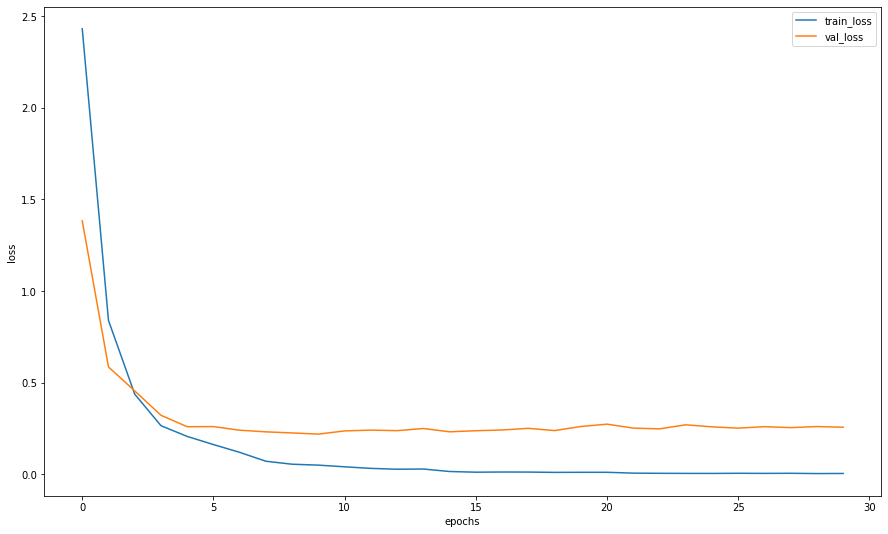

In [10]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = models.resnet18(pretrained=True)
    clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
    clf = clf.to('cuda')
        
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
    submit[f'fold_{fold+1}'] = preds    
    break

In [11]:
torch.cuda.empty_cache()

###  Submission

In [12]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_resnet18_sgd_lrs7.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
